In [ ]:
from google.colab import files
uploaded = files.upload()

Saving preprocess_df.csv to preprocess_df.csv


In [ ]:
import pandas as pd
file_path = '/content/preprocess_df.csv'  # Update with your uploaded file's path
df = pd.read_csv(file_path)
print("Dataset Preview:\n", df.head())

Dataset Preview:
              category  rating label  \
0  Home_and_Kitchen_5     5.0    CG   
1  Home_and_Kitchen_5     5.0    CG   
2  Home_and_Kitchen_5     5.0    CG   
3  Home_and_Kitchen_5     1.0    CG   
4  Home_and_Kitchen_5     5.0    CG   

                                               text_  \
0  Love this!  Well made, sturdy, and very comfor...   
1  love it, a great upgrade from the original.  I...   
2  This pillow saved my back. I love the look and...   
3  Missing information on how to use it, but it i...   
4  Very nice set. Good quality. We have had the s...   

                                        cleaned_text  cleaned_text_length  \
0  love well made sturdy comfortable love itvery ...                   52   
1       love great upgrade original mine couple year                   44   
2            pillow saved back love look feel pillow                   39   
3        missing information use great product price                   43   
4                nice set

In [ ]:
# Replace NaN values in 'cleaned_text' with an empty string
df['cleaned_text'] = df['cleaned_text'].fillna('')

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from scipy.sparse import hstack


In [ ]:

# Encode labels (e.g., 'label' column: 1 for fake, 0 for real)
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# Scale numerical features
scaler = StandardScaler()
numerical_features = scaler.fit_transform(df[['cleaned_text_length', 'rating']])

# Vectorize text using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1, 3))
X_text = tfidf_vectorizer.fit_transform(df['cleaned_text'])

# Combine features
X = hstack([X_text, numerical_features])
y = df['label']


In [ ]:

# Compute average TF-IDF vector for fake reviews
fake_reviews = df[df['label'] == 1]['cleaned_text']  # Fake reviews
fake_tfidf = tfidf_vectorizer.transform(fake_reviews)
avg_fake_vector = np.mean(fake_tfidf, axis=0)

# Ensure avg_fake_vector is a 2D array and convert it to a NumPy array
avg_fake_vector = np.asarray(avg_fake_vector).reshape(1, -1)

# Compute cosine similarity for each review
cosine_similarities = cosine_similarity(X_text, avg_fake_vector)

# Add the cosine similarity to the dataframe
df['cosine_similarity'] = cosine_similarities.flatten()

# Additional metrics: average and max cosine similarity
df['avg_similarity'] = cosine_similarities.mean(axis=1)
df['max_similarity'] = cosine_similarities.max(axis=1)

# Add these features to the dataset
similarity_features = np.array(df[['cosine_similarity', 'avg_similarity', 'max_similarity']])
X_enhanced = hstack([X, similarity_features])



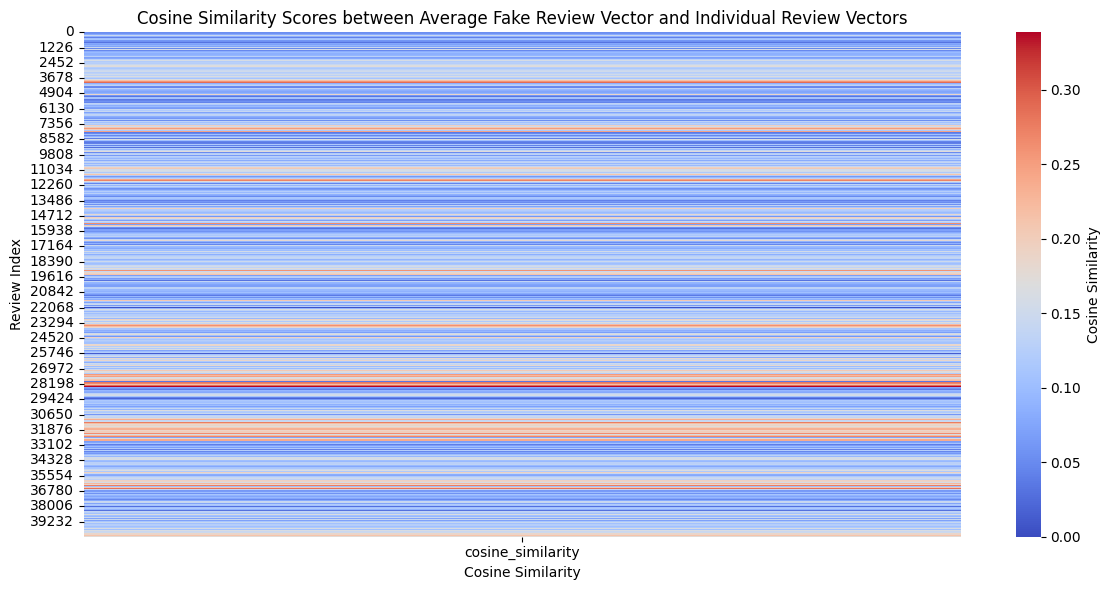

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
X_text_dense = X_text.toarray()

# Compute cosine similarity between average fake review vector and all review vectors
cosine_similarities = cosine_similarity(avg_fake_vector, X_text_dense)[0]
cosine_df = pd.DataFrame({'cleaned_text': range(len(cosine_similarities)),
                          'cosine_similarity': cosine_similarities})

# Create a pivot table for heatmap visualization
cosine_pivot = cosine_df.pivot_table(index='cleaned_text', values='cosine_similarity')

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(cosine_pivot, cmap="coolwarm", cbar_kws={'label': 'Cosine Similarity'})
plt.title("Cosine Similarity Scores between Average Fake Review Vector and Individual Review Vectors")
plt.xlabel("Cosine Similarity")
plt.ylabel("Review Index")
plt.tight_layout()
plt.show()

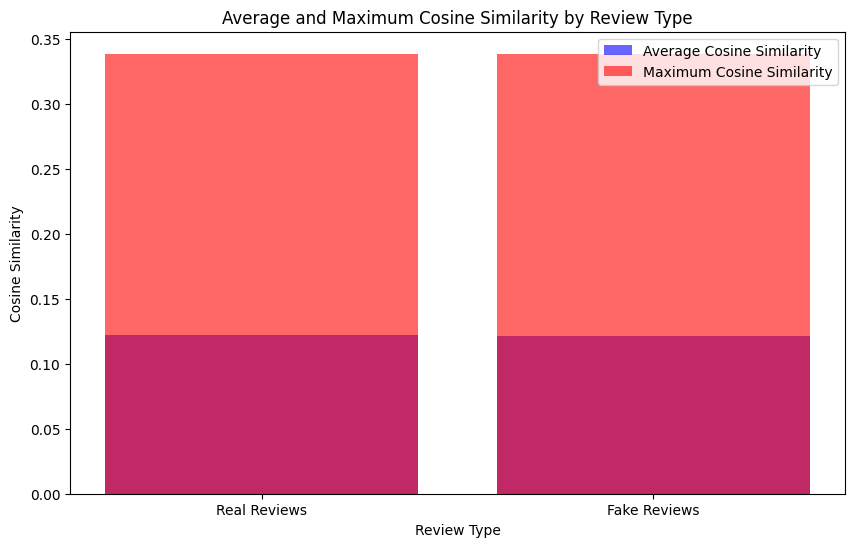

In [ ]:
avg_sim = df.groupby('label')['cosine_similarity'].mean()
max_sim = df.groupby('label')['cosine_similarity'].max()

labels = ['Real Reviews', 'Fake Reviews']
x = range(len(labels))

plt.figure(figsize=(10, 6))
plt.bar(x, avg_sim, color='blue', alpha=0.6, label='Average Cosine Similarity')
plt.bar(x, max_sim, color='red', alpha=0.6, label='Maximum Cosine Similarity')
plt.xticks(x, labels)
plt.title('Average and Maximum Cosine Similarity by Review Type')
plt.xlabel('Review Type')
plt.ylabel('Cosine Similarity')
plt.legend()
plt.show()


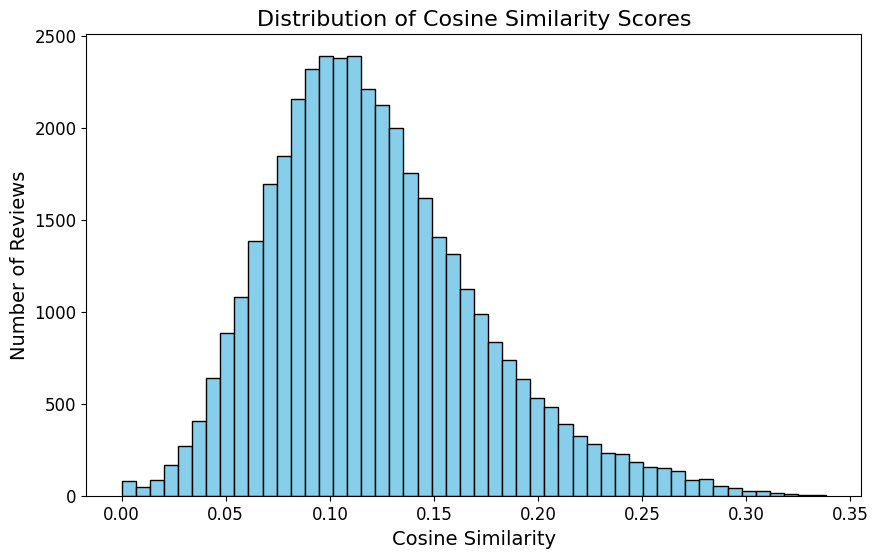

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(cosine_similarities, bins=50, color='skyblue', edgecolor='black')

# Update font sizes
plt.title('Distribution of Cosine Similarity Scores', fontsize=16)
plt.xlabel('Cosine Similarity', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.xticks(fontsize=12)  # Font size for x-axis ticks
plt.yticks(fontsize=12)  # Font size for y-axis ticks

plt.show()



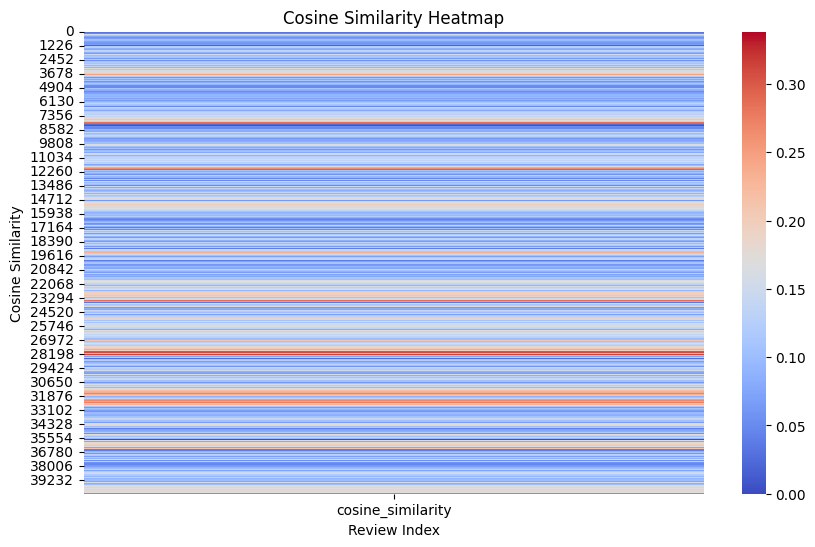

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(cosine_pivot, cmap='coolwarm', annot=False, cbar=True)
plt.title('Cosine Similarity Heatmap')
plt.xlabel('Review Index')
plt.ylabel('Cosine Similarity')
plt.show()


In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_enhanced, y, test_size=0.3, random_state=42)


In [ ]:
decision_tree = DecisionTreeClassifier(random_state=42, max_depth=10)
random_forest = RandomForestClassifier(random_state=42, n_estimators=200, max_depth=15)
logistic_regression = LogisticRegression(random_state=42, solver='liblinear', C=0.5)
svm = SVC(probability=True, random_state=42, C=1, kernel='linear')
xgboost = XGBClassifier(random_state=42, n_estimators=200, learning_rate=0.1, max_depth=10)

# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('decision_tree', decision_tree),
        ('random_forest', random_forest),
        ('logistic_regression', logistic_regression),
        ('svm', svm)

    ],
    voting='soft',
    weights=[1, 3, 1, 3]
)

# Train the model
voting_clf.fit(X_train, y_train)


VotingClassifier(estimators=[('decision_tree',
                              DecisionTreeClassifier(max_depth=10,
                                                     random_state=42)),
                             ('random_forest',
                              RandomForestClassifier(max_depth=15,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('logistic_regression',
                              LogisticRegression(C=0.5, random_state=42,
                                                 solver='liblinear')),
                             ('svm',
                              SVC(C=1, kernel='linear', probability=True,
                                  random_state=42))],
                 voting='soft', weights=[1, 3, 1, 3])

In [ ]:
# Predictions and metrics
y_pred = voting_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy after adding cosine similarity: {accuracy:.4f}")
print("Classification Report:")
print(report)


Accuracy after adding cosine similarity: 0.8814
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      6066
           1       0.87      0.89      0.88      6064

    accuracy                           0.88     12130
   macro avg       0.88      0.88      0.88     12130
weighted avg       0.88      0.88      0.88     12130



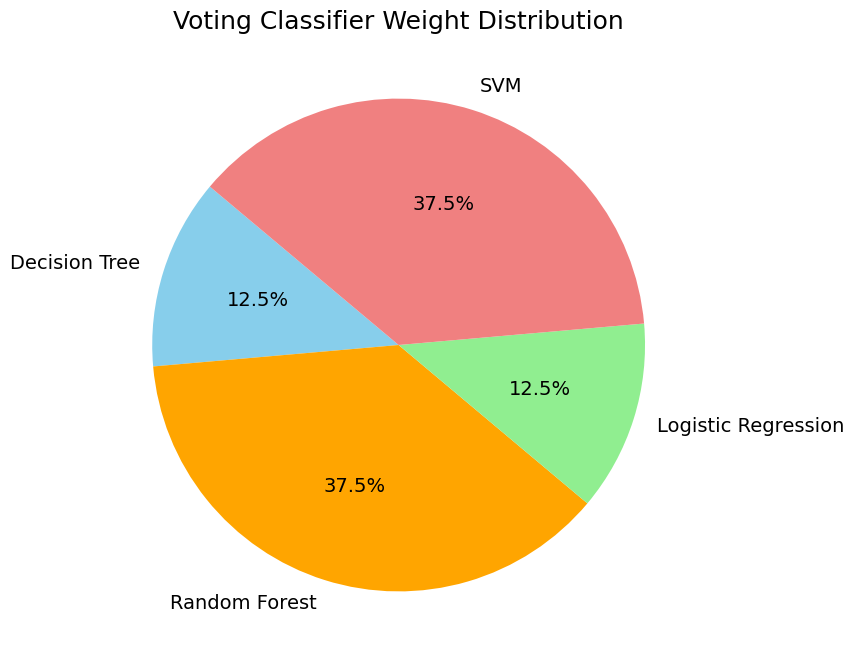

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
weights = [1, 3, 1, 3]
classifiers = ['Decision Tree', 'Random Forest', 'Logistic Regression', 'SVM']

# Create the pie chart with larger font sizes
plt.pie(weights,
        labels=classifiers,
        autopct='%1.1f%%',
        startangle=140,
        colors=['skyblue', 'orange', 'lightgreen', 'lightcoral'],
        textprops={'fontsize': 14})  # Adjust font size for labels and percentages

# Set the title with a larger font size
plt.title('Voting Classifier Weight Distribution', fontsize=18)

# Display the pie chart
plt.show()

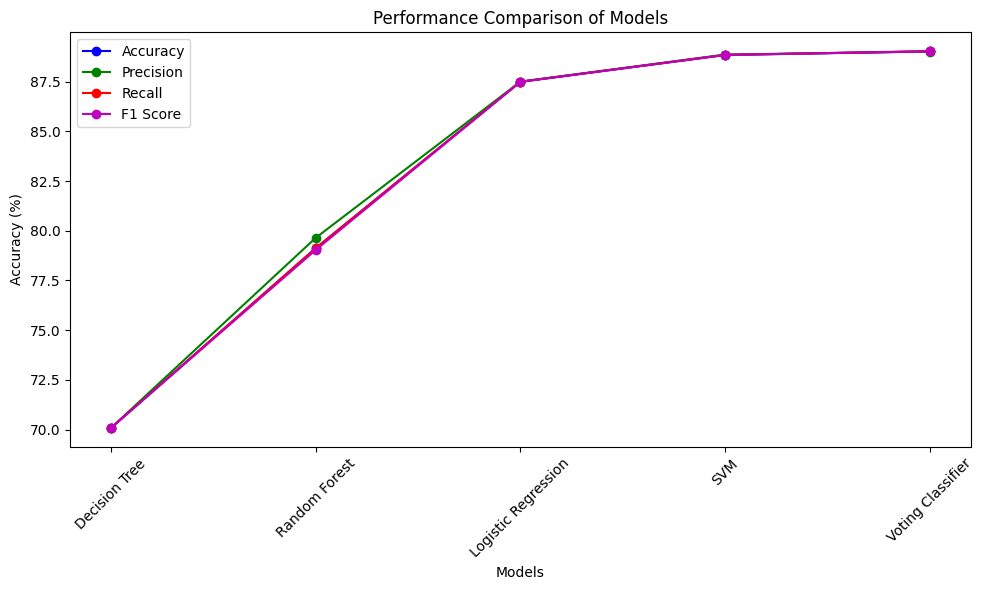

In [ ]:
import matplotlib.pyplot as plt

# Data from the table
models = ['Decision Tree', 'Random Forest', 'Logistic Regression', 'SVM', 'Voting Classifier']
accuracy = [70.08, 79.12, 87.49, 88.84, 89.02]
precision = [70.08, 79.64, 87.50, 88.86, 89.01]
recall = [70.08, 79.12, 87.49, 88.84, 89.03]
f1_score = [70.08, 79.03, 87.49, 88.84, 89.02]

# Plotting the line graph
plt.figure(figsize=(10, 6))
plt.plot(models, accuracy, marker='o', label='Accuracy', linestyle='-', color='b')
plt.plot(models, precision, marker='o', label='Precision', linestyle='-', color='g')
plt.plot(models, recall, marker='o', label='Recall', linestyle='-', color='r')
plt.plot(models, f1_score, marker='o', label='F1 Score', linestyle='-', color='m')

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Performance Comparison of Models')
plt.xticks(rotation=45)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


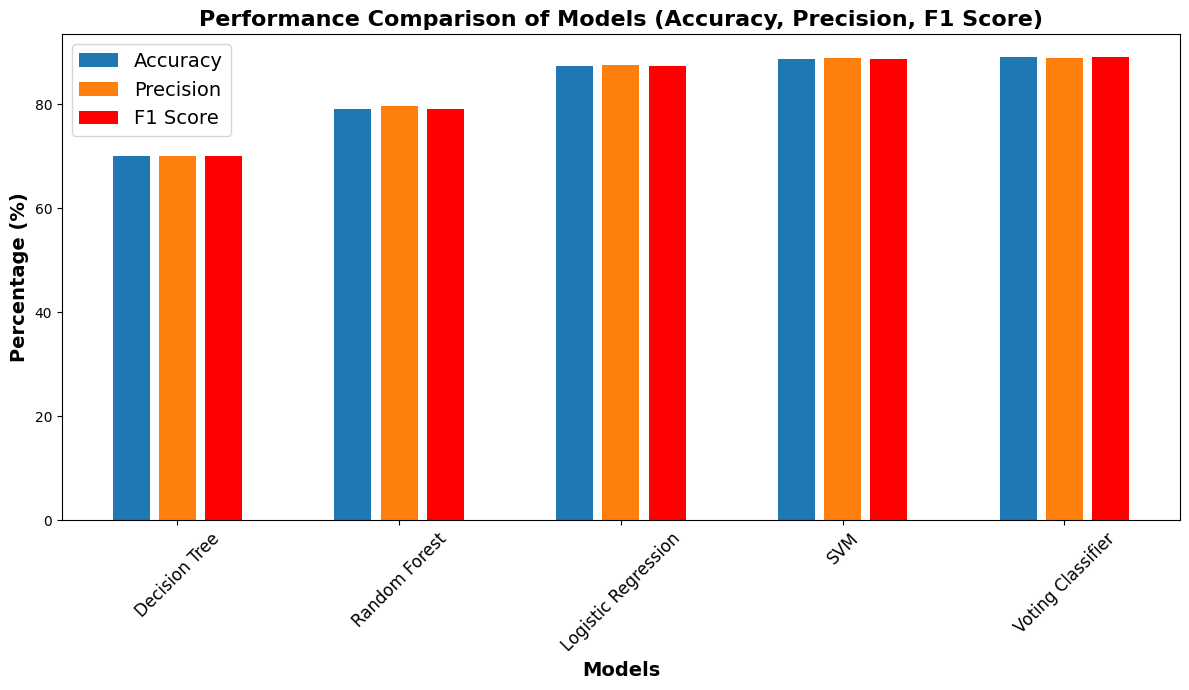

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the table
models = ['Decision Tree', 'Random Forest', 'Logistic Regression', 'SVM', 'Voting Classifier']
accuracy = [70.08, 79.12, 87.49, 88.84, 89.04]
precision = [70.08, 79.64, 87.50, 88.86, 89.01]
f1_score = [70.08, 79.03, 87.49, 88.84, 89.04]

# Set the width of the bars
bar_width = 0.2
spacing = 0.05

# Set positions for the bars on the x-axis with a little space between consecutive bars
index = np.arange(len(models)) * 1.2  # Add a factor for spacing between groups

# Define new color scheme
accuracy_color = '#1f77b4'  # Vibrant blue
precision_color = '#ff7f0e'  # Bright orange
f1_score_color = 'red'  # Vibrant green

# Create the bar graph
plt.figure(figsize=(12, 7))
plt.bar(index - bar_width - spacing, accuracy, bar_width, label='Accuracy', color=accuracy_color)  # Blue
plt.bar(index, precision, bar_width, label='Precision', color=precision_color)  # Orange
plt.bar(index + bar_width + spacing, f1_score, bar_width, label='F1 Score', color=f1_score_color)  # Green

# Adding labels and title with increased font size
plt.xlabel('Models', fontsize=14, fontweight='bold')
plt.ylabel('Percentage (%)', fontsize=14, fontweight='bold')
plt.title('Performance Comparison of Models (Accuracy, Precision, F1 Score)', fontsize=16, fontweight='bold')

# Adjust the x-ticks for better readability
plt.xticks(index, models, rotation=45, fontsize=12)

# Add a legend with larger font size
plt.legend(fontsize=14)

# Improve layout for readability
plt.tight_layout()

# Show the plot
plt.show()





